In [1]:
# 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# 라이브러리 모음집
import json, os, random, shutil, platform, yaml, cv2, torch, torchvision

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.patches as patches
import albumentations as A

from collections import Counter, defaultdict
from PIL import Image, ImageDraw, ImageFont
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
from albumentations.pytorch import ToTensorV2

In [3]:
# 재현성 및 디바이스 설정
def set_seed(seed=42):
  random.seed(seed); np.random.seed(seed)
  torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = False
  torch.backends.cudnn.benchmark = True  # 이미지엔 대체로 이게 빠름

set_seed()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ", device)

device:  cpu


In [4]:
# 한글 오류 제거 코드
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

!apt-get update -qq
!apt-get install fonts-nanum* -qq

import warnings
warnings.filterwarnings(action='ignore')

path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' # 나눔 고딕
font_name = fm.FontProperties(fname=path, size=10).get_name() # 기본 폰트 사이즈 : 10
plt.rc('font', family=font_name)

fm.fontManager.addfont(path)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 3s (3,932 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126374 files and dire

In [5]:
origin_dir = '/content/drive/MyDrive/딥러닝' # 절대경로지정

# 절대경로 다음 경로추가
image_dir = os.path.join(origin_dir, 'images', 'train_images')
annotation_dir = os.path.join(origin_dir, 'images', 'train_annotations')

image_files = [f for f in os.listdir(image_dir) if f.endswith('png')] # png들을 리스트로 추출
print('이미지 갯수: ',len(image_files))
print('이미지 샘플 5개: ', image_files[:5])

json_files = []
for roots, dirs, files in os.walk(annotation_dir):  # annotation_dir안의 모든 하위 폴더 탐색 후 .json 파일 찾아 리스트로 저장
  for f in files:
    if f.endswith('.json'):
      json_files.append(os.path.join(roots, f))

print('annotation 파일 갯수: ', len(json_files))
print('json 파일 샘플 5개: ', json_files[:5])

with open(json_files[0], 'r', encoding='utf-8') as f:
    json_data = json.load(f)

#print('키: ', json_data.keys()) # key값 확인
print('이미지 수: ', len(json_data['images']))
print('어노테이션 수: ', len(json_data['annotations']))
print('카테고리 수: ', len(json_data['categories']))

categories = pd.DataFrame(json_data['categories'])
#print('key값: ', categories.keys()) # key값 확인
print('유니크 클래스 수: ', categories.shape[0])
print('클래스 이름 예시: ', categories.head())

이미지 갯수:  1489
이미지 샘플 5개:  ['K-003351-013900-021325_0_2_0_2_75_000_200.png', 'K-003351-013900-022074_0_2_0_2_70_000_200.png', 'K-003351-013900-022074_0_2_0_2_90_000_200.png', 'K-003351-013900-016232_0_2_0_2_75_000_200.png', 'K-003351-013900-016688_0_2_0_2_70_000_200.png']
annotation 파일 갯수:  4526
json 파일 샘플 5개:  ['/content/drive/MyDrive/딥러닝/images/train_annotations/K-001900-016548-018110-021026_json/K-001900/K-001900-016548-018110-021026_0_2_0_2_70_000_200.json', '/content/drive/MyDrive/딥러닝/images/train_annotations/K-001900-016548-018110-021026_json/K-001900/K-001900-016548-018110-021026_0_2_0_2_75_000_200.json', '/content/drive/MyDrive/딥러닝/images/train_annotations/K-001900-016548-018110-021026_json/K-001900/K-001900-016548-018110-021026_0_2_0_2_90_000_200.json', '/content/drive/MyDrive/딥러닝/images/train_annotations/K-001900-016548-018110-021026_json/K-016548/K-001900-016548-018110-021026_0_2_0_2_90_000_200.json', '/content/drive/MyDrive/딥러닝/images/train_annotatio

상위 10개 클래스: [('기넥신에프정(은행엽엑스)(수출용)', 514), ('일양하이트린정 2mg', 240), ('보령부스파정 5mg', 180), ('뮤테란캡슐 100mg', 172), ('가바토파정 100mg', 143), ('동아가바펜틴정 800mg', 139), ('아토젯정 10/40mg', 113), ('리바로정 4mg', 111), ('리피토정 20mg', 109), ('크레스토정 20mg', 108)]
bbox 평균 크기: 259.326557666814 288.7459125055236


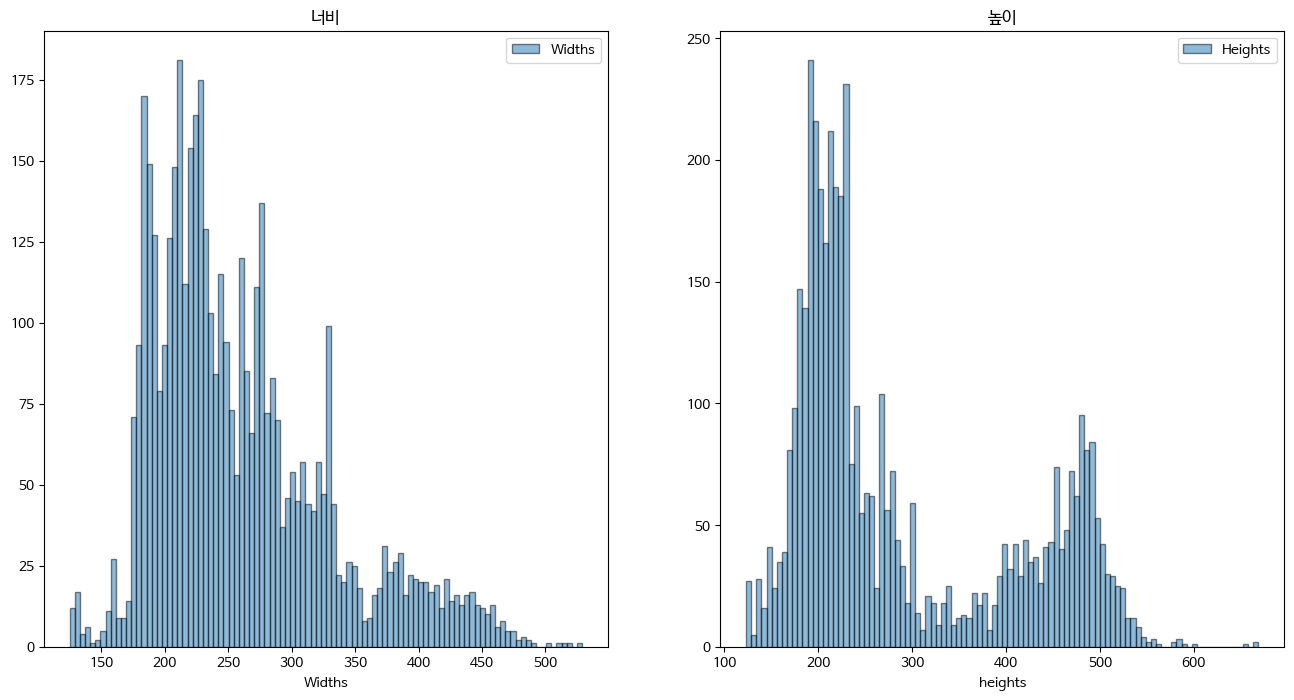

In [39]:
all_classes = []
all_boxes = []

for json_file in json_files:
  with open(json_file, 'r', encoding='utf-8') as f:
    data = json.load(f)

  # 카테고리 정보
  for category in data['categories']:
    all_classes.append(category['name'])

  # 바운딩 박스 정보
  for annotation in data['annotations']:
    if 'bbox' in annotation and len(annotation['bbox']) == 4:
      all_boxes.append(annotation['bbox'])

# 클래스 분포
class_counter = Counter(all_classes)
print('상위 10개 클래스:', class_counter.most_common(10))

# 바운딩 박스 크기 분포
widths = [b[2] for b in all_boxes]
heights = [b[3] for b in all_boxes]
print('bbox 평균 크기:', np.mean(widths), np.mean(heights))

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.hist(widths, bins=100, alpha=0.5, label='Widths', edgecolor='black')
plt.title('너비')
plt.xlabel('Widths')
plt.legend()

plt.subplot(1,2,2)
plt.hist(heights, bins=100, alpha=0.5, label='Heights', edgecolor='black')
plt.title('높이')
plt.xlabel('heights')
plt.legend()
plt.show()

In [7]:
sizes = []
for f in os.listdir(image_dir):
  if f.endswith('.png'):
    path = os.path.join(image_dir, f)
    with Image.open(path) as img:
      sizes.append(img.size)  # (width, height)

# 유니크한 사이즈 종류
unique_sizes = Counter(sizes)

print('총 이미지 개수:', len(sizes))
print('유니크 사이즈 개수:', len(unique_sizes))
print('상위 10개 사이즈:', unique_sizes.most_common(10))

총 이미지 개수: 1489
유니크 사이즈 개수: 1
상위 10개 사이즈: [((976, 1280), 1489)]


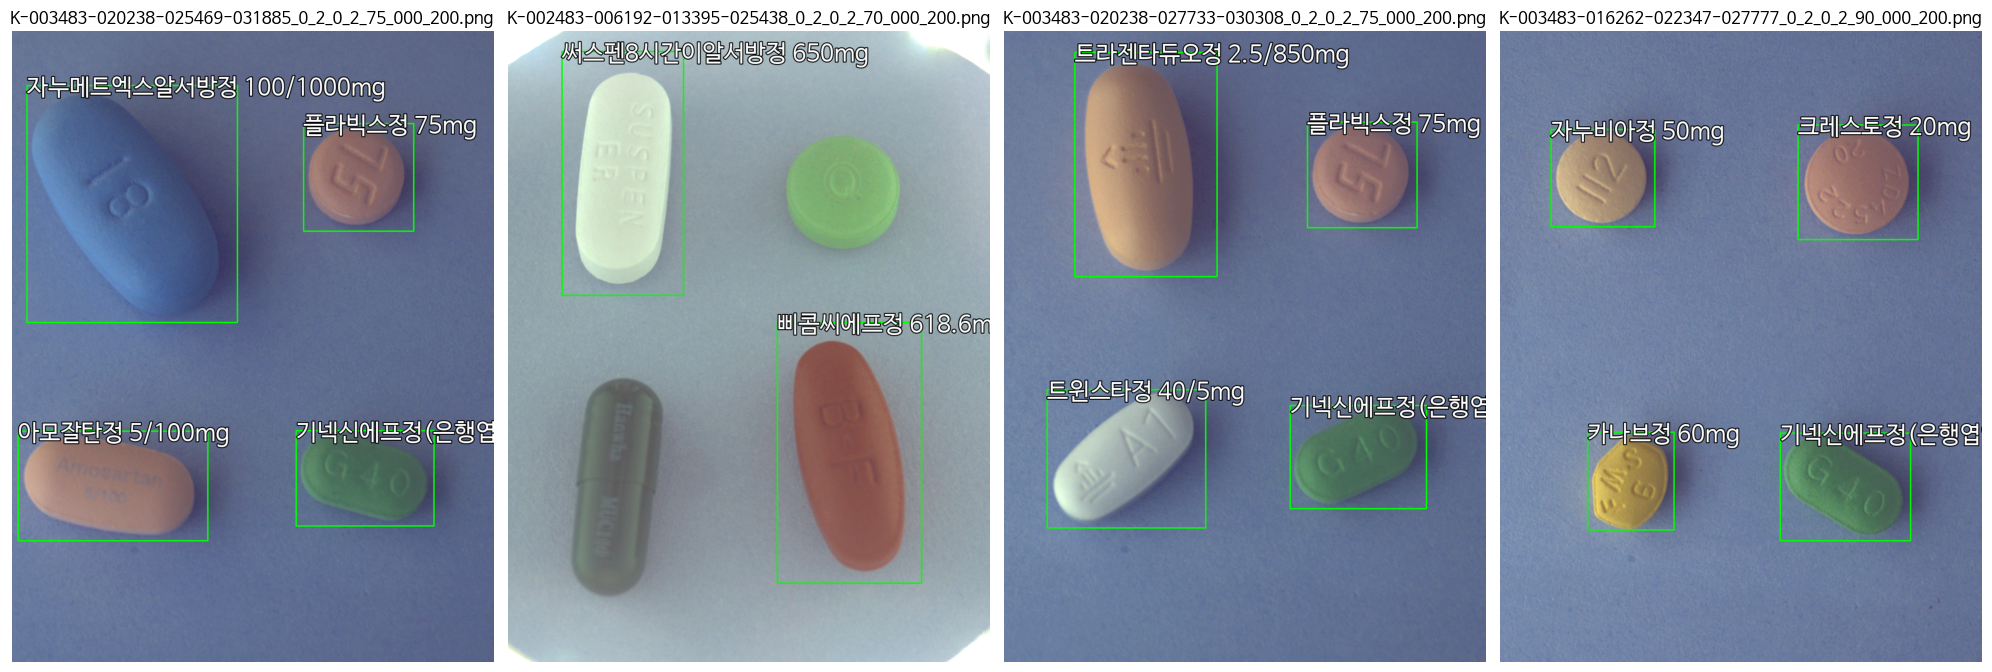

In [46]:
"""#1개의 랜덤 이미지 선택
sample_json = random.choice(json_files) # 샘플 랜덤 선택
with open(sample_json, 'r', encoding='utf-8') as f:
  data = json.load(f)

categories_dict = {category['id']: category['name'] for category in data['categories']}

plt.figure(figsize=(20, 8))

for i, image_info in enumerate(data['images'][:5]):
  image_path = os.path.join(image_dir, image_info['file_name'])
  image = cv2.imread(image_path)

  for annotation in data['annotations']:
    if annotation['image_id'] == image_info['id']:
      x, y, w, h = annotation['bbox']
      x1, y1, x2, y2 = int(x), int(y), int(x+w), int(y+h)
      cv2.rectangle(image, (x1,y1), (x2,y2), (0,255,0), 2)
      category_id = annotation['category_id']
      label = categories_dict.get(category_id, "unknown")
      cv2.putText(image, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,255,0), 2)


  plt.subplot(1, 5, i+1)
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.title(image_info['file_name'])

plt.show()
"""
# 이건 여러개의 랜덤 이미지 선택해서 보여주기
all_images = []
all_annotations = []
all_categories = []
font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'  # Colab에서 쓰이는 경로
font = ImageFont.truetype(font_path, 48)

for json_file in json_files:
    with open(json_file, 'r', encoding='utf-8') as f:
        random_image = json.load(f)
        all_images.extend(random_image['images'])
        all_annotations.extend(random_image['annotations'])
        all_categories.extend(random_image['categories'])

# 카테고리 아이디 -> 이름 매핑
categories_dict = {category['id']: category['name'] for category in all_categories}
# 랜덤으로 4개 이미지 선택
sample_images = random.sample(all_images, min(4, len(all_images)))

plt.figure(figsize=(20, 8))

for i, image_info in enumerate(sample_images):
    image_path = os.path.join(image_dir, image_info['file_name'])
    image = cv2.imread(image_path).copy()

    # 해당 이미지의 바운딩 박스만 선택
    annotations = [ann for ann in all_annotations if ann['image_id'] == image_info['id']]
    for annotation in annotations:
        x, y, w, h = annotation['bbox']
        x1, y1, x2, y2 = int(x), int(y), int(x+w), int(y+h)
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # 박스 그리기
        category_id = annotation['category_id']                   # 클래스 이름 쓰기
        label = categories_dict.get(category_id, "unknown")
        #cv2.putText(image, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2, cv2.LINE_AA)  # 검은 테두리 cv2.putText는 한글이랑 안맞음
        #cv2.putText(image, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 1, cv2.LINE_AA) # 흰 글씨
        image_PIL = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) # openCV RGB -> PIL RGB
        draw = ImageDraw.Draw(image_PIL)

        # stroke_width + stroke_fill으로 테두리 글자 효과
        draw.text((x1, max(0, y1-22)), label, font=font, fill=(255,255,255), stroke_width=2, stroke_fill=(0,0,0))

        image = cv2.cvtColor(np.array(image_PIL), cv2.COLOR_RGB2BGR) # 다시 PIL RGB -> openCV BRG로 변환

    plt.subplot(1, 4, i+1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(image_info['file_name'])
    plt.axis('off')

plt.tight_layout()
plt.show()

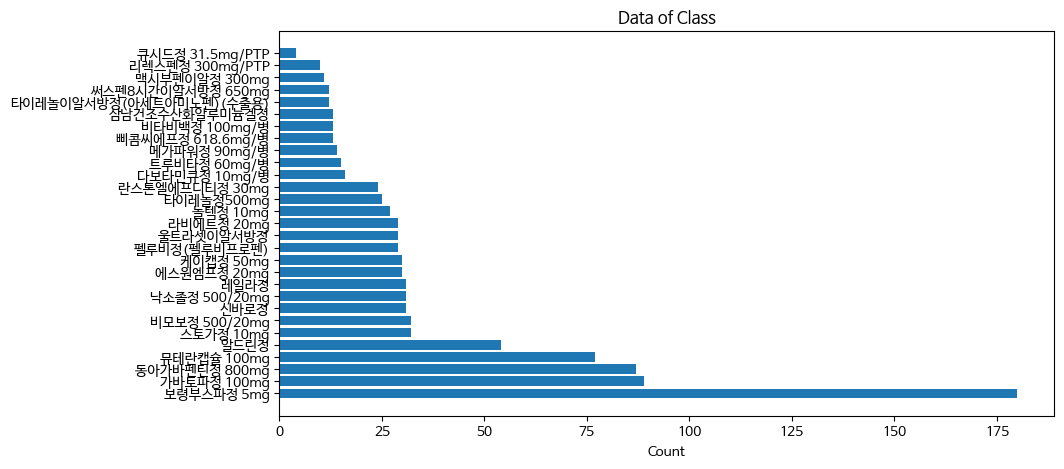

In [19]:
top_classes = class_counter.most_common(29)
names, counts = zip(*top_classes)

plt.figure(figsize=(10,5))
plt.barh(names, counts)
plt.xlabel('Count')
plt.title('Data of Class')
plt.show()

In [53]:
label_root = os.path.join(origin_dir, 'data_yolo/labels') #딥러닝/data_yolo/labels
os.makedirs(os.path.join(label_root, 'train'), exist_ok=True)
os.makedirs(os.path.join(label_root, 'val'), exist_ok=True)

In [54]:
from pathlib import Path

image_dir = os.path.join(origin_dir, 'images', 'train_images')
annotation_dir = os.path.join(origin_dir, 'images', 'train_annotations')

yolo_root = os.path.join(origin_dir, 'data_yolo')
image_train_dir = os.path.join(yolo_root, 'images/train')
image_val_dir = os.path.join(yolo_root, 'images/val')
label_train_dir = os.path.join(yolo_root, 'labels/train')
label_val_dir = os.path.join(yolo_root, 'labels/val')

for datas in [image_train_dir, image_val_dir, label_train_dir, label_val_dir]:
  os.makedirs(datas, exist_ok=True)

json_files = []
for roots, _, files in os.walk(annotation_dir):
  for f in files:
    if f.endswith('.json'):
      json_files.append(os.path.join(roots, f))

print('총 JSON 개수:', len(json_files))

class_map = {}
class_counter = 0
for json_file in json_files:
  with open(json_file, 'r', encoding='utf-8') as f:
    data = json.load(f)

  for category in data.get('categories', []):
    name = category['name']

    if name not in class_map:
      class_map[name] = class_counter
      class_counter += 1

print('클래스 개수:', len(class_map))

image_to_json = defaultdict(list)
for json_file in json_files:
  with open(json_file, 'r', encoding='utf-8') as f:
    data = json.load(f)

    image_name = data['images'][0]['file_name']
    image_to_json[image_name].append(json_file)

print('총 이미지 개수:', len(image_to_json))


def convert_jsons_to_txt(json_list, save_dir, class_map):
  if not json_list: return None
  with open(json_list[0], 'r', encoding='utf-8') as f:
    first_data = json.load(f)

  image = first_data['images'][0]
  image_w, image_h = image['width'], image['height']
  image_name = image['file_name']
  label_path = os.path.join(save_dir, image_name.replace('.png', '.txt'))

  yolo_lines = []
  for json_file in json_list:
    with open(json_file, 'r', encoding='utf-8') as f:
      data = json.load(f)

    id_to_name = {category['id']: category['name'] for category in data['categories']}
    for annotation in data['annotations']:
      if 'bbox' not in annotation or len(ann['bbox']) != 4: continue

      x, y, w, h = annotation['bbox']
      x_center = (x + w / 2) / image_w
      y_center = (y + h / 2) / image_h
      w /= image_w
      h /= image_h

      category_id = annotation['category_id']
      if category_id not in id_to_name: continue

      name = id_to_name[category_id]
      if name not in class_map: continue

      class_id = class_map[name]
      yolo_lines.append(f'{class_id} {x_center} {y_center} {w} {h}')

    if yolo_lines:
      with open(label_path, 'w', encoding='utf-8') as f:
        f.write('\n'.join(yolo_lines) + '\n')

    return image_name

images = list(image_to_json.keys())
random.shuffle(images)
split_idx = int(len(images) * 0.8)
train_images, val_images = images[:split_idx], images[split_idx:]

print('Train 이미지:', len(train_images))
print('Val 이미지:', len(val_images))


def symlink(src, dst):
  try:
    os.symlink(src, dst)
  except AttributeError:
    import subprocess
    subprocess.call(['mklink', '/D', dst, src], shell=True)

for image_name in train_images:
  image_src = os.path.join(image_dir, image_name)
  image_dst = os.path.join(image_train_dir, image_name)
  if not os.path.exists(image_dst):
    try:
      symlink(image_src, image_dst)
    except:
      shutil.copy(image_src, image_dst)
  convert_jsons_to_txt(image_to_json[image_name], label_train_dir, class_map)

for image_name in val_images:
  image_src = os.path.join(image_dir, image_name)
  image_dst = os.path.join(image_val_dir, image_name)
  if not os.path.exists(image_dst):
    try:
      symlink(image_src, image_dst)
    except:
      shutil.copy(image_src, image_dst)
  convert_jsons_to_txt(image_to_json[image_name], label_val_dir, class_map)

print('data_yolo/images/train:', len(os.listdir(image_train_dir)))
print('data_yolo/labels/train:', len(os.listdir(label_train_dir)))

총 JSON 개수: 4526
클래스 개수: 73
총 이미지 개수: 1489
Train 이미지: 1191
Val 이미지: 298
data_yolo/images/train: 1479
data_yolo/labels/train: 1479


In [56]:
class_ids = set()

for split in ['train', 'val']:
  split_dir = os.path.join(label_root, split)
  for f in os.listdir(split_dir):
    if f.endswith('.txt'):
      with open(os.path.join(split_dir, f), 'r', encoding='utf-8') as ftxt:
        for line in ftxt:
          class_id = int(line.split()[0])
          class_ids.add(class_id)

print('클래스 개수:', len(class_ids))

클래스 개수: 72


In [57]:
yaml_path = '/content/drive/MyDrive/딥러닝/data_yolo/yolo_data.yaml'
data_yaml = {
    'train': '../data_yolo/images/train',
    'val': '../data_yolo/images/val',
    'nc': len(class_map),
    'names': [name for name, _ in sorted(class_map.items(), key=lambda x: x[1])]
}

with open(yaml_path, 'w', encoding='utf-8') as f:
  yaml.dump(data_yaml, f, allow_unicode=True)

print(f'yaml 저장 완료 → {yaml_path}')

yaml 저장 완료 → /content/drive/MyDrive/딥러닝/data_yolo/yolo_data.yaml
